# VAEでクラス識別ができないか検討してみる
- 目的
    - 生成モデルでクラス識別できるものかを確かめてみる
- 目標
    - VAEを使って2クラス分類タスクを解いてみる
- 手段
    - mnist手書き数字の任意の2文字を使う
    - 潜在空間を2次元にして可視化できるようにする
    - $p(z|C_K)$をガウス関数でパラメトリックにモデル化できるかやってみる
    - $p(C_k|z)$をベイズの公式で計算できるかやってみる

In [34]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import kde
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import mse, binary_crossentropy

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [36]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [37]:
# ラベルに対応するインデックスを取得する
indices_train = [np.where(y_train == i)[0] for i in range(10)]
indices_test = [np.where(y_test == i)[0] for i in range(10)]

# データをラベルごとに分割する
data_train = [x_train[indices_train[i]] for i in range(10)]
data_test  = [x_test[indices_test[i]] for i in range(10)]

In [38]:
latent_dim = 2
batch_size = 128
epochs = 10

In [39]:
# エンコーダーの定義
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 潜在変数のサンプリング関数の定義
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

# 潜在変数のサンプリング関数を使用して、潜在変数zを生成します。
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# デコーダーの定義
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# エンコーダーとデコーダーを結合してVAEモデルを作成します。
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [40]:
reconstruction_loss = mse(inputs, outputs) * original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [41]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[0],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[0], None))

Epoch 1/10
47/47 [==============================] - 3s 18ms/step - loss: 73.5312 - val_loss: 50.6687
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 50.0085 - val_loss: 47.9772
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 43.6162 - val_loss: 42.5409
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 41.5156 - val_loss: 41.5824
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 39.9406 - val_loss: 36.9786
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 35.8728 - val_loss: 35.4053
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 34.9184 - val_loss: 34.8368
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 34.2747 - val_loss: 34.4780
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 33.7113 - val_loss: 33.7945
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 33.2842 - val_los

1/1 [==============================] - 0s 15ms/step


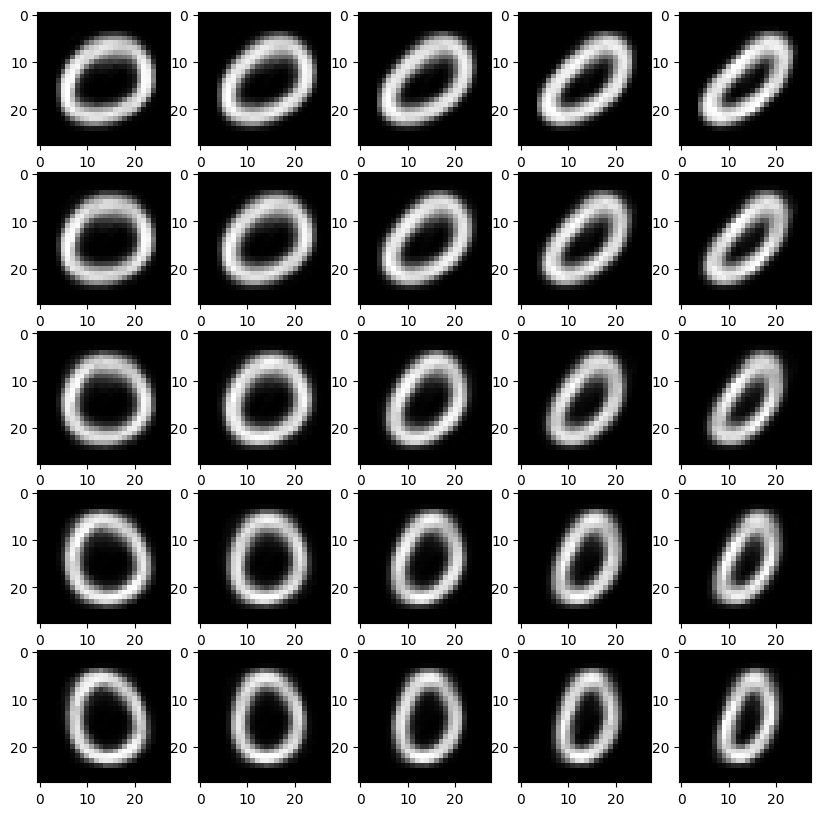

In [42]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [43]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
# z_mean, z_log_var, z = encoder.predict(data_test[0], batch_size=batch_size)
z_mean, z_log_var, z = encoder.predict(data_train[0], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

47/47 [==============================] - 0s 4ms/step
[[ 0.27244112 -0.24407403]
 [ 0.21231404 -0.4001037 ]
 [ 1.6039516   0.6639997 ]
 ...
 [ 1.0398031  -0.95183265]
 [ 1.2865765  -1.0199027 ]
 [ 0.9130869  -1.4795218 ]]
[[-2.961938  -2.7374604]
 [-2.754803  -2.3574388]
 [-2.2338102 -2.3536165]
 ...
 [-2.1461778 -1.9994141]
 [-2.3524942 -2.2190173]
 [-2.5497842 -1.9097475]]
[[ 0.2752291  -0.23675947]
 [ 0.18382289 -0.34359947]
 [ 1.6061575   0.67217875]
 ...
 [ 0.824749   -0.93425316]
 [ 1.3266692  -1.006518  ]
 [ 0.9041914  -1.5561537 ]]


/tmp/ipykernel_8371/3073362744.py:14: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


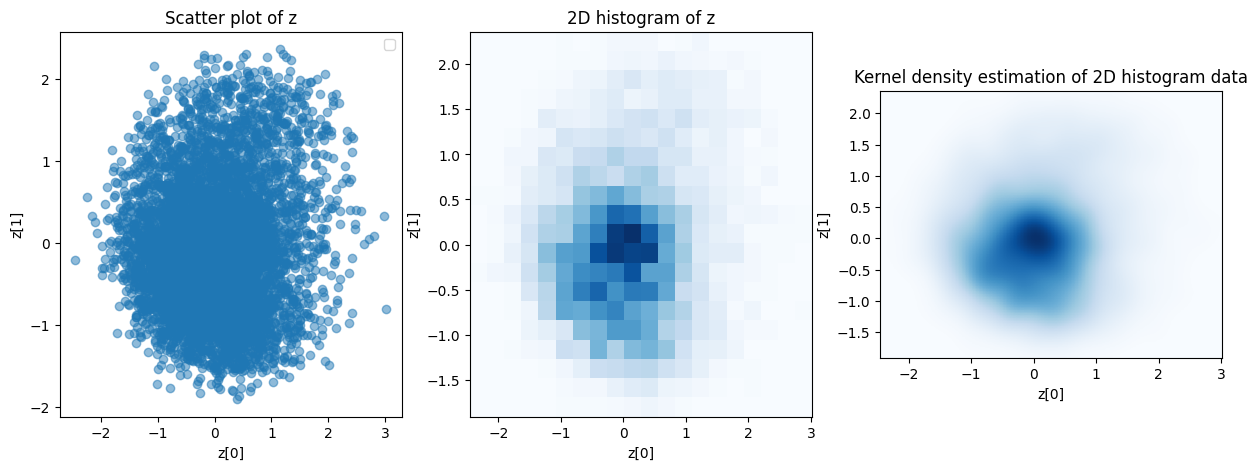

In [44]:
# x = z_mean[:, 0]
# y = z_mean[:, 1]
x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()


Epoch 1/10
53/53 [==============================] - 1s 14ms/step - loss: 25.0878 - val_loss: 15.7456
Epoch 2/10
53/53 [==============================] - 1s 12ms/step - loss: 13.8574 - val_loss: 12.3808
Epoch 3/10
53/53 [==============================] - 1s 14ms/step - loss: 12.2167 - val_loss: 11.6249
Epoch 4/10
53/53 [==============================] - 1s 13ms/step - loss: 11.6348 - val_loss: 11.1872
Epoch 5/10
53/53 [==============================] - 1s 15ms/step - loss: 11.3177 - val_loss: 10.8124
Epoch 6/10
53/53 [==============================] - 1s 13ms/step - loss: 11.0315 - val_loss: 10.7504
Epoch 7/10
53/53 [==============================] - 1s 14ms/step - loss: 10.9441 - val_loss: 10.5383
Epoch 8/10
53/53 [==============================] - 1s 13ms/step - loss: 10.8199 - val_loss: 10.4765
Epoch 9/10
53/53 [==============================] - 1s 13ms/step - loss: 10.7404 - val_loss: 10.3525
Epoch 10/10
1/1 [==============================] - 0s 15ms/step


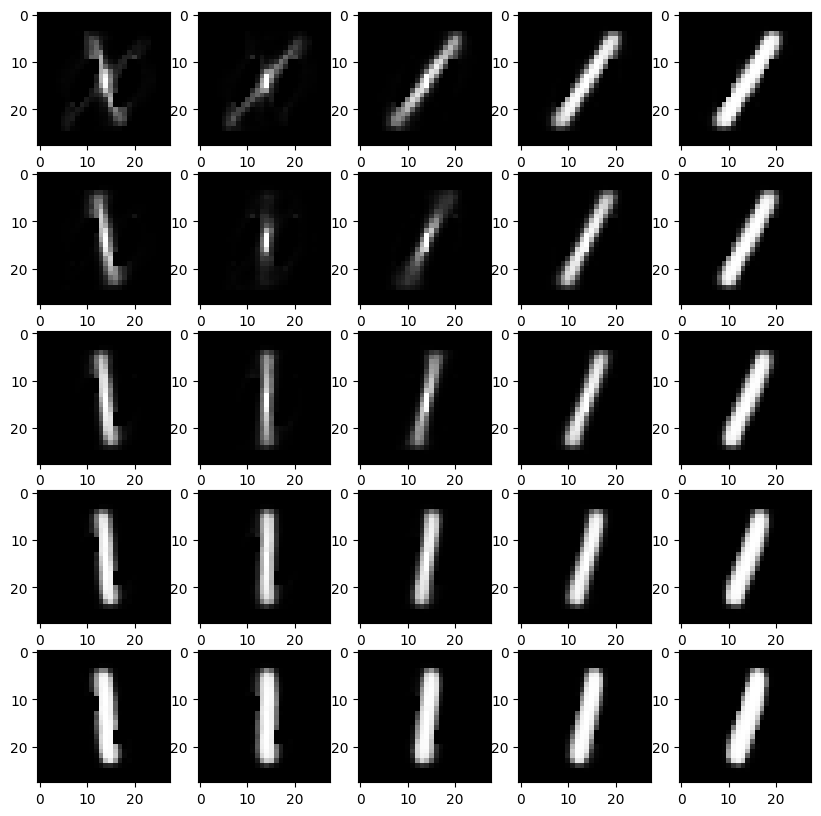

In [45]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[1],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[1], None))

x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

53/53 [==============================] - 0s 5ms/step
[[ 0.60764635 -0.8444589 ]
 [-1.315852    0.6056546 ]
 [-0.8135607   0.14139071]
 ...
 [ 0.3363818  -0.6776181 ]
 [-0.06129823 -1.4725254 ]
 [ 0.05890725 -0.83463424]]
[[-2.2637813 -2.3811693]
 [-1.9655753 -1.8397155]
 [-2.2896135 -2.1789577]
 ...
 [-2.5324104 -2.647318 ]
 [-2.3254175 -2.179008 ]
 [-2.492144  -2.46174  ]]
[[ 0.6132503  -0.8340135 ]
 [-1.3785809   0.7004801 ]
 [-0.8114745   0.15113063]
 ...
 [ 0.34143686 -0.687919  ]
 [-0.00879613 -1.4778696 ]
 [ 0.04991587 -0.8330435 ]]


/tmp/ipykernel_8371/1573821036.py:19: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


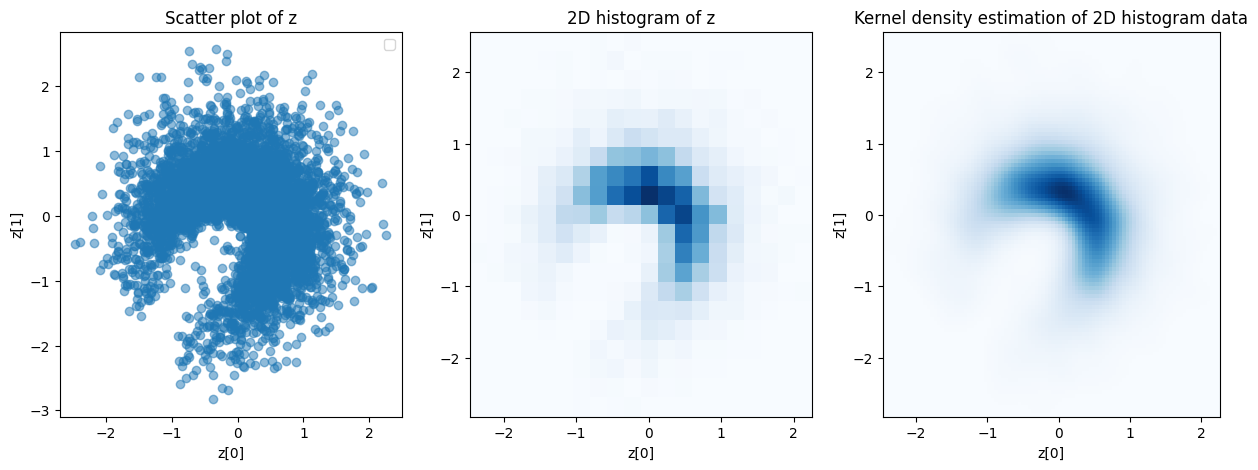

In [46]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_train[1], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [47]:
data_2class_train = np.concatenate(data_train[:2])
data_2class_test = np.concatenate(data_test[:2])
np.random.shuffle(data_2class_train)

# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_2class_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_2class_test, None))


Epoch 1/10
99/99 [==============================] - 2s 14ms/step - loss: 31.6480 - val_loss: 23.7433
Epoch 2/10
99/99 [==============================] - 1s 13ms/step - loss: 23.2242 - val_loss: 22.3474
Epoch 3/10
99/99 [==============================] - 1s 13ms/step - loss: 22.3300 - val_loss: 21.7306
Epoch 4/10
99/99 [==============================] - 1s 13ms/step - loss: 21.8449 - val_loss: 21.3854
Epoch 5/10
99/99 [==============================] - 1s 12ms/step - loss: 21.4591 - val_loss: 21.0028
Epoch 6/10
99/99 [==============================] - 1s 12ms/step - loss: 21.1876 - val_loss: 20.7396
Epoch 7/10
99/99 [==============================] - 1s 12ms/step - loss: 20.8825 - val_loss: 20.3828
Epoch 8/10
99/99 [==============================] - 1s 12ms/step - loss: 20.5997 - val_loss: 20.1765
Epoch 9/10
99/99 [==============================] - 1s 12ms/step - loss: 20.3661 - val_loss: 19.9657
Epoch 10/10
99/99 [==============================] - 1s 13ms/step - loss: 20.2196 - val_los

1/1 [==============================] - 0s 16ms/step


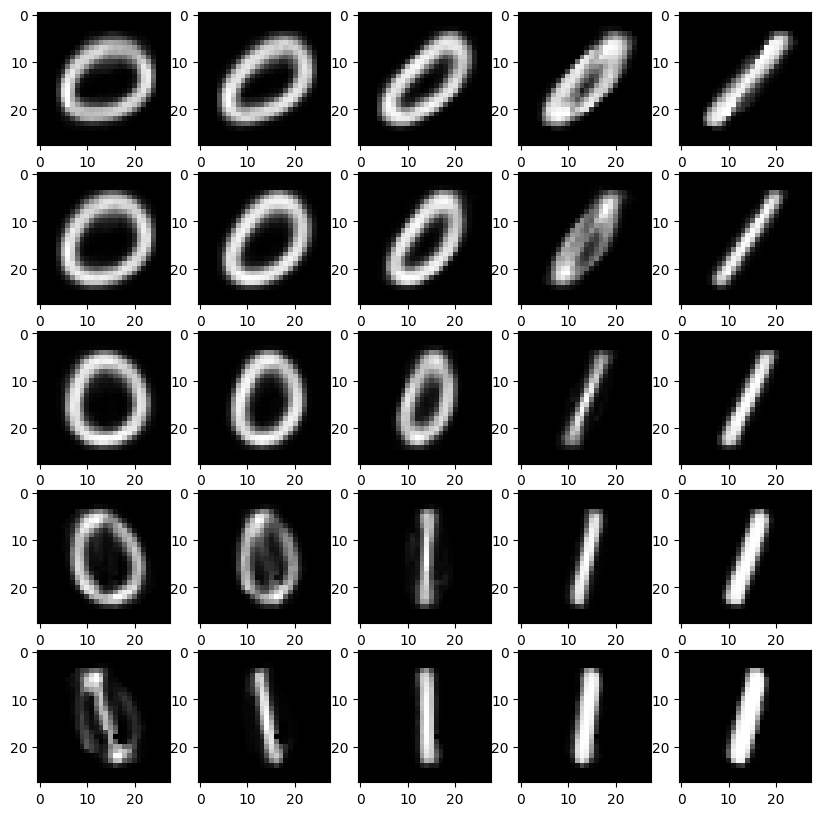

In [48]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

99/99 [==============================] - 0s 2ms/step
[[-0.24312893 -0.50408435]
 [-0.34602255 -0.6181727 ]
 [ 0.10376777 -0.2795997 ]
 ...
 [ 0.9181683  -0.26555973]
 [ 1.1287805  -0.76873064]
 [ 0.79595876 -0.40332878]]
[[-3.091705  -3.0804698]
 [-2.7711163 -2.8402169]
 [-3.5658078 -3.2514203]
 ...
 [-2.6634364 -3.117539 ]
 [-2.7710013 -3.252974 ]
 [-2.9944086 -3.2986372]]
[[-0.21710488 -0.44762018]
 [-0.3645777  -0.61811435]
 [ 0.07854965 -0.28904286]
 ...
 [ 1.0071965  -0.35306707]
 [ 1.1542314  -0.6650248 ]
 [ 0.76886886 -0.31541416]]


/tmp/ipykernel_8371/1345161528.py:22: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


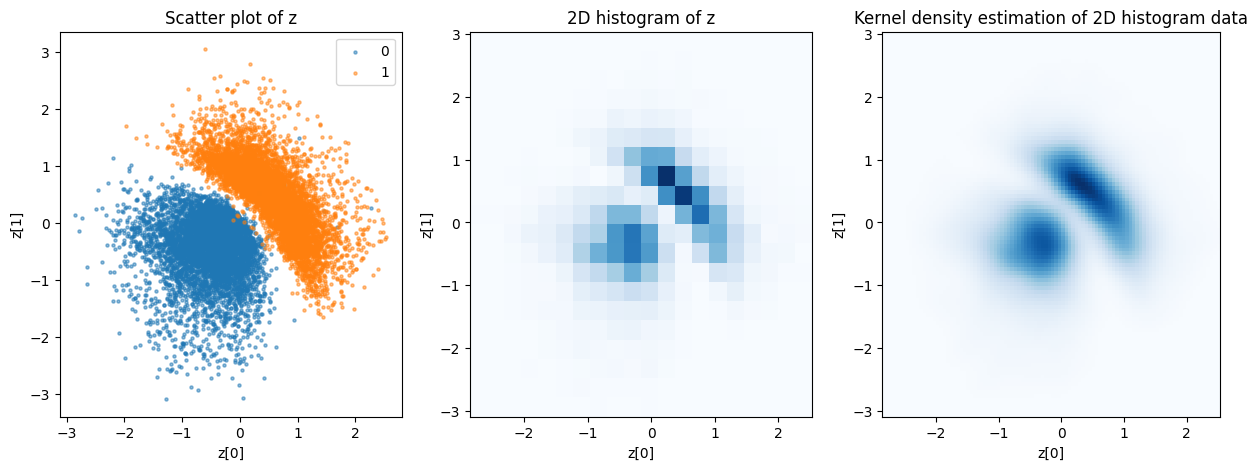

In [52]:
data_2class_train = np.concatenate(data_train[:2])
label_2class_train = np.concatenate([np.zeros(len(data_train[0])), np.ones(len(data_train[1]))])

# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_2class_train, batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x[label_2class_train==0], y[label_2class_train==0], alpha=0.5, label='0', s=5)
axs[0].scatter(x[label_2class_train==1], y[label_2class_train==1], alpha=0.5, label='1', s=5)
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()

In [74]:
class1 = 1
class2 = 7

data_2class_train = np.concatenate([data_train[class1], data_train[class2]])
label_2class_train = np.concatenate([np.ones(len(data_train[class1]))*class1, np.ones(len(data_train[class2]))*class2])

# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_2class_train, batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values1 = np.vstack([x[label_2class_train==class1], y[label_2class_train==class1]])
kernel1 = kde.gaussian_kde(values1)
f1 = np.reshape(kernel1(positions).T, xx.shape)

values2 = np.vstack([x[label_2class_train==class2], y[label_2class_train==class2]])
kernel2 = kde.gaussian_kde(values2)
f2 = np.reshape(kernel2(positions).T, xx.shape)


102/102 [==============================] - 0s 3ms/step
[[ 1.1972089  -0.3057378 ]
 [-0.3349998   1.4966937 ]
 [-0.18942529  0.9047982 ]
 ...
 [ 0.53164953 -0.5154482 ]
 [ 0.22935337  0.0314623 ]
 [ 0.28474295 -1.1654747 ]]
[[-2.4860878 -3.0144792]
 [-2.4539967 -2.1040459]
 [-2.744966  -2.523843 ]
 ...
 [-2.315164  -2.257685 ]
 [-3.0054846 -2.8681948]
 [-2.2431712 -1.698891 ]]
[[ 1.0957785  -0.29505634]
 [-0.48620707  1.4954729 ]
 [-0.11670726  1.0565176 ]
 ...
 [ 0.33207923 -0.6860845 ]
 [ 0.18386206  0.13370639]
 [ 0.40405005 -1.1404155 ]]


/tmp/ipykernel_8371/1940600678.py:25: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel1 = kde.gaussian_kde(values1)
/tmp/ipykernel_8371/1940600678.py:29: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel2 = kde.gaussian_kde(values2)


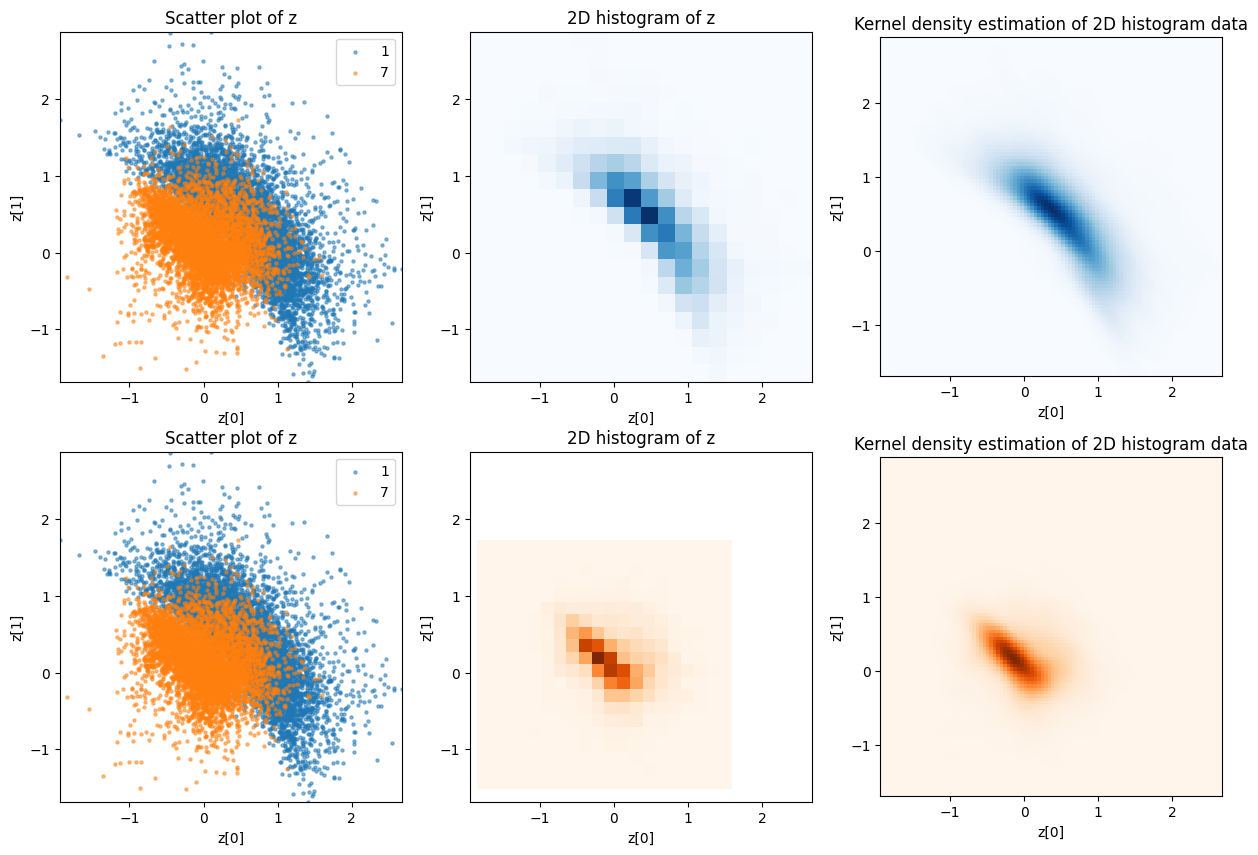

In [75]:
# Plot the results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[0][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[0][0].legend()
axs[0][0].set_xlabel("z[0]")
axs[0][0].set_ylabel("z[1]")
axs[0][0].set_title("Scatter plot of z")
axs[0][0].set_xlim([xmin, xmax])
axs[0][0].set_ylim([ymin, ymax])

axs[1][0].scatter(x[label_2class_train==class1], y[label_2class_train==class1], alpha=0.5, label=class1, s=5)
axs[1][0].scatter(x[label_2class_train==class2], y[label_2class_train==class2], alpha=0.5, label=class2, s=5)
axs[1][0].legend()
axs[1][0].set_xlabel("z[0]")
axs[1][0].set_ylabel("z[1]")
axs[1][0].set_title("Scatter plot of z")
axs[1][0].set_xlim([xmin, xmax])
axs[1][0].set_ylim([ymin, ymax])


axs[0][1].hist2d(x[label_2class_train==class1], y[label_2class_train==class1], bins=20, cmap='Blues')
axs[0][1].set_xlabel("z[0]")
axs[0][1].set_ylabel("z[1]")
axs[0][1].set_title("2D histogram of z")
axs[0][1].set_xlim([xmin, xmax])
axs[0][1].set_ylim([ymin, ymax])

axs[1][1].hist2d(x[label_2class_train==class2], y[label_2class_train==class2], bins=20, cmap='Oranges')
axs[1][1].set_xlabel("z[0]")
axs[1][1].set_ylabel("z[1]")
axs[1][1].set_title("2D histogram of z")
axs[1][1].set_xlim([xmin, xmax])
axs[1][1].set_ylim([ymin, ymax])

axs[0][2].imshow(np.rot90(f1), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[0][2].plot(x, y, 'k.', markersize=2)
axs[0][2].set_xlim([xmin, xmax])
axs[0][2].set_ylim([ymin, ymax])
axs[0][2].set_xlabel("z[0]")
axs[0][2].set_ylabel("z[1]")
axs[0][2].set_title("Kernel density estimation of 2D histogram data")

axs[1][2].imshow(np.rot90(f2), cmap='Oranges', extent=[xmin, xmax, ymin, ymax])
# axs[1][2].plot(x, y, 'k.', markersize=2)
axs[1][2].set_xlim([xmin, xmax])
axs[1][2].set_ylim([ymin, ymax])
axs[1][2].set_xlabel("z[0]")
axs[1][2].set_ylabel("z[1]")
axs[1][2].set_title("Kernel density estimation of 2D histogram data")

plt.show()